In [801]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time

In [1000]:
precision = np.double

def gen_plane_point(min, max):
    a = precision(np.random.uniform(min, max))
    b = precision(np.random.uniform(min, max))
    return (a, b)

def gen_plane_points(n, min, max):
    return [gen_plane_point(min, max) for _ in range(n)]


def gen_circle_point(r, s):
    fi = np.random.uniform(0.0, 2*math.pi)
    x = precision(r*math.cos(fi)) + s[0]
    y = precision(r*math.sin(fi)) + s[1]
    return (x, y)

def gen_circle_points(n, r, s):
    return [gen_circle_point(r, s) for _ in range(n)]
    
def gen_rect_point(min_x, max_x, min_y, max_y):
    a = np.random.uniform(min_x, max_x)
    b = np.random.uniform(min_y, max_y)
    rand = np.random.randint(0, 4)
    if (rand == 0):
        a = max_x
    elif (rand == 1):
        a = min_x
    elif (rand == 2):
        b = max_y
    else:
        b = min_y
    return (precision(a), precision(b))

def gen_rect_points(n, a, b, c, d):
    return [gen_rect_point(b[0], d[0], b[1], d[1]) for _ in range(n)]


def gen_rect_x_point(min, max):
    a = precision(np.random.uniform(min, max))
    return (precision(0), a)

def gen_rect_y_point(min, max):
    a = precision(np.random.uniform(min, max))
    return (a, precision(0))

def gen_rect_diag_x_point(min, max):
    a = precision(np.random.uniform(min, max))
    return (a, a)

def gen_rect_diag_y_point(min, max):
    a = precision(np.random.uniform(min, max))
    return ((max-min)-a, a)

def gen_rect_diag_xy_points(a, b, c, d, diag_n, rect_n):
    diag_x = [gen_rect_diag_x_point(a[0], c[0]) for _ in range(diag_n)]
    diag_y = [gen_rect_diag_y_point(a[1], c[1]) for _ in range(diag_n)]
    rect_x = [gen_rect_x_point(a[0], c[0]) for _ in range(rect_n)]
    rect_y = [gen_rect_y_point(a[1], c[1]) for _ in range(rect_n)]
    i = 0
    points = []
    for x in diag_x:
        points.insert(i, x)
        i += 1
    for x in diag_y:
        points.insert(i, x)
        i += 1
    for x in rect_x:
        points.insert(i, x)
        i += 1
    for x in rect_y:
        points.insert(i, x)
        i += 1
    return points

In [1001]:
a1,b1,c1,d1 = ((-10, 10), (-10, -10), (10,-10),(10,10))
a2,b2,c2,d2 = ((0, 0), (10, 0), (10, 10), (0, 10))
s = (0, 0)

plane_points = gen_plane_points(100, -100, 100)
circle_points = gen_circle_points(100, 10, s)
rect_points = gen_rect_points(100, a1, b1, c1, d1)
rect_boost_points = gen_rect_diag_xy_points(a2, b2, c2, d2, 20, 25)
sets = [plane_points, circle_points, rect_points, rect_boost_points]

In [1002]:
#alternatives
a1,b1,c1,d1 = ((4e-10, 16e-10), (4e-10, 3e-10), (8e-10, 3e-10), (8e-10,16e-10))
a2,b2,c2,d2 = ((0, 0), (10e14, 0), (10e14, 10e14), (0, 10e14))
plane_points = gen_plane_points(400, -10e10, 10e10)
circle_points = gen_circle_points(1000, 10e-10, (10e-10, 10e-10))
rect_points = gen_rect_points(100, a1, b1, c1, d1)
rect_boost_points = gen_rect_diag_xy_points(a2, b2, c2, d2, 100, 200)
sets = [plane_points, circle_points, rect_points, rect_boost_points]

In [1003]:
def plot_set(x, y, size=0.5):
    plt.figure(figsize=(12,12))
    plt.ylabel('y')
    plt.xlabel('x')
    plt.scatter(x,y, color="magenta", s=size)
    plt.show()

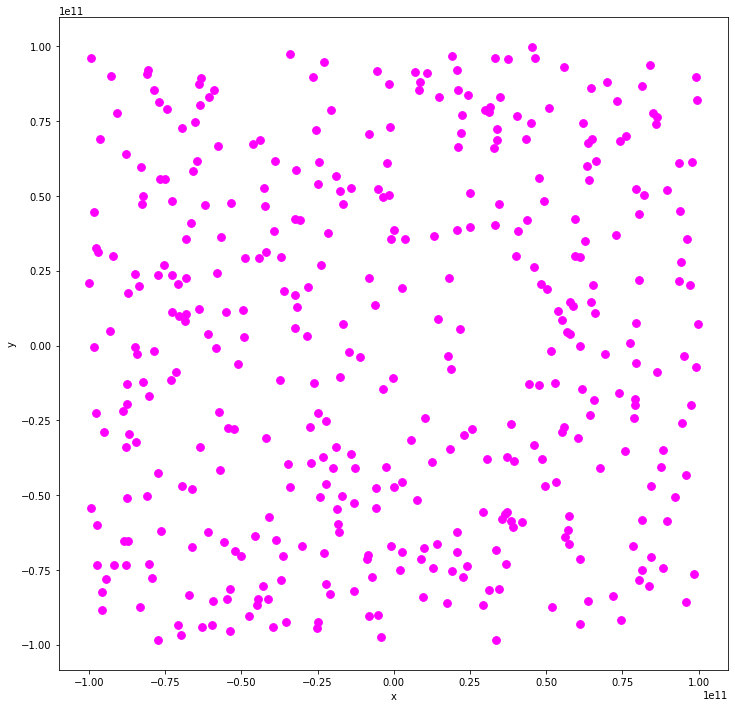

In [1004]:
x,y = np.array(sets[0]).T
plot_set(x, y, size=60)

In [1005]:
eps = 10e-4

def graham(points):
    def det(p1, p2, p3):
        return (p2[0] - p1[0])*(p3[1] - p1[1]) - (p2[1] - p1[1])*(p3[0] - p1[0])
        
    def slope(p1, p2):
        s = (p1[1]-p2[1])/(p1[0]-p2[0]) if abs(p1[0]-p2[0]) > eps else float('inf')
        return s
      
    # znajdz pierwszy punkt i usun go z puli punktow
    start = min(points, key=lambda p: (p[0], p[1]))
    points_cpy = [x for x in points]
    points_cpy.pop(points_cpy.index(start))
  
    # posortuj ze wzgledu na nachylenie 
    points_cpy.sort(key=lambda p: (slope(p, start), -p[1], p[0]))
      
    # dodawaj punkty posortowane jezeli nie sa wspoliniowe 
    result = [start]
    for p in points_cpy:
        result.append(p)
        while len(result) > 2 and det(result[-3], result[-2], result[-1]) < eps:
            result.pop(-2)
            
    # jezeli dwa ostatnie i startowy sa wspoliniowe to wywal srodkowy        
    if det(result[-2], result[-1], result[0]) < eps:
        result.pop(-1)
        
    return result

In [1006]:
graham(rect_points)

[(4e-10, 3.056646843260106e-10)]

In [1007]:
def graham_times(sets):
    for set in sets:
        t = time.time()
        graham(set)
        print(str(time.time()-t))
        
graham_times(sets)

0.0022809505462646484
0.0038709640502929688
0.0003809928894042969
0.003101825714111328


In [1008]:
def plot_set_hull(points, hull, size):
    x,y = np.array(points).T
    h_x, h_y = np.array(hull).T
    print("Liczba punktow w otoczce: " + str(len(hull)))
    plt.figure(figsize=(12,12))
    plt.ylabel('y')
    plt.xlabel('x')
    plt.scatter(x,y, color="magenta", s=size)
    plt.scatter(h_x[1:], h_y[1:], color="blue", s=size*2)
    plt.scatter(h_x[0:1], h_y[0:1], color="red", s=size*2.5)
    plt.fill(h_x, h_y, edgecolor="green", fill=False)
    plt.show()

Eps: 0
Liczba punktow w otoczce: 14


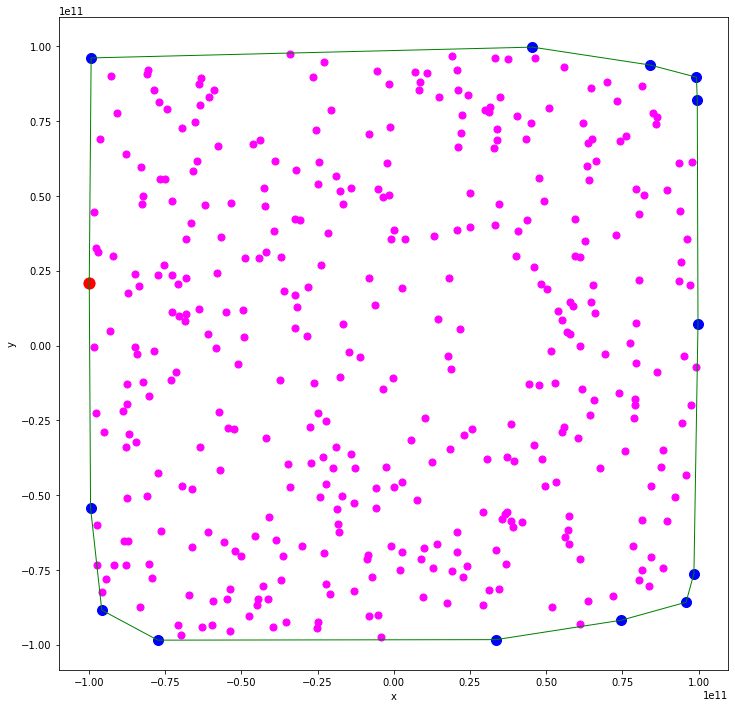

In [1009]:
eps = 0
print("Eps: " + str(eps))
plot_set_hull(sets[0], graham(sets[0]), size=50)

In [1010]:
def jarvis(points):
    # wyznacznik pozwalajacy okreslic orientacje
    def det(p1, p2, p3):
        return (p2[0] - p1[0])*(p3[1] - p1[1]) - (p2[1] - p1[1])*(p3[0] - p1[0])
    
    # odleglosc miedzy punktami bez pierwiastka, bo bez znaczenia
    def dist(a,b):
        return (a[0]-b[0])**2+(a[1]-b[1])**2

    # wyznaczenie punktu startowego
    points_cpy = [x for x in points]
    start = min(points_cpy, key = lambda x: x[0])
    start_idx = points_cpy.index(start)
    p1 = start_idx
    hull = [start]
    
    while(True):
        p2 = (p1 + 1) % len(points_cpy)
        for p3 in range(len(points_cpy)):
            if p3 == p2:
                continue
            d = det(points_cpy[p1], points_cpy[p2], points_cpy[p3])
            if d > 0 or (d == 0 and dist(points_cpy[p1], points_cpy[p2]) > dist(points_cpy[p1], points_cpy[p3])):
                p2 = p3
        p1 = p2
        if p1 == start_idx:
            break
        hull.append(p2)
    return hull

In [1011]:
def cmp(a):
    if a > eps:
        return 1
    elif a < -eps:
        return -1
    else:
        return 0

def turn(p1, p2, p3):
    return cmp((p2[0]-p1[0])*(p3[1]-p1[1])-(p3[0]-p1[0])*(p2[1]-p1[1]))

def dist(p1, p2):
    dx, dy = p2[0]-p1[0], p2[1]-p1[1]
    return dx * dx + dy * dy

def next_hull_point(points, p1):
    p2 = p1
    for p3 in points:
        d = turn(p1, p2, p3)
        if d == -1 or d == 0 and dist(p1, p3) > dist(p1, p2):
            p2 = p3
    return p2

def jarvis(points):
    hull = [min(points)]
    for p in hull:
        q = next_hull_point(points, p)
        if q != hull[0]:
            hull.append(q)
        else:
            break
    return hull

In [1012]:
def jarvis_times(sets):
    for set in sets:
        t = time.time()
        jarvis(set)
        print(str(time.time()-t))
        
jarvis_times(sets)

0.009634733200073242
1.1432199478149414
0.0010421276092529297
0.005674123764038086


Eps: 0
Liczba punktow w otoczce: 7


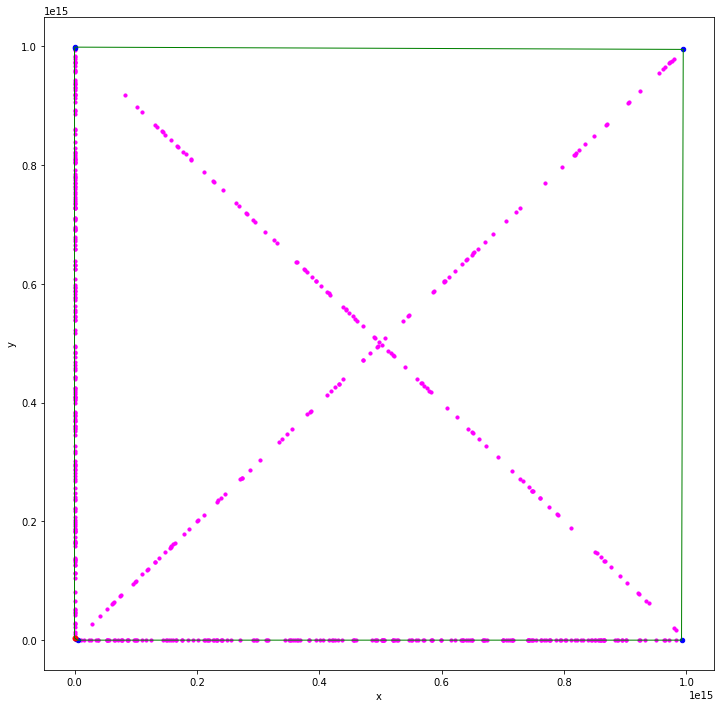

In [1028]:
eps = 0
print("Eps: " + str(eps))
plot_set_hull(sets[3], jarvis(sets[3]), size=10)